In [2]:
from robobrowser import RoboBrowser
from collections import namedtuple

import random
import pandas as pd
import numpy as np

In [3]:
browser = RoboBrowser(parser="html5lib")
token = "bmlrbGFzX21hbnVlbCU0MGdteC5kZToxNzU1ODk0NTgwOTExOlNIQTI1Njo1YmJkMDA0NWFkODZjYTFhYTc3MDQyY2VjNmRmNWMzN2M1ZGYwMWFjNWQ1NzA4YWM4NmViNzc2OGJlZDBlMzY4"
communities = ['bundesligavorgetippt', 'markforsterultras']
browser.session.cookies['login'] = token

In [4]:
MatchTip = namedtuple("MatchTip", "match_day match_id home_team away_team home_tip away_tip")

def build_tippabgabe_url(community, matchday):
    return f"https://www.kicktipp.de/{community}/tippabgabe?&spieltagIndex={matchday}"

def get_matches(browser, community, matchday):
    browser.open(build_tippabgabe_url(community, matchday))
    home_teams = [td.text for td in browser.select('tr > td:nth-child(2)')]
    away_teams = [td.text for td in browser.select('tr > td:nth-child(3)')]
    value_default_0 = lambda inp: int(inp.attrs["value"]) if "value" in inp.attrs else 0
    home_tips = [value_default_0(inp) for inp in browser.select('input[id$="_heimTipp"]')]
    away_tips = [value_default_0(inp) for inp in browser.select('input[id$="_gastTipp"]')]
    matches = []
    for i in range(len(home_teams)):
        try:
            matches.append(MatchTip(matchday, i, home_teams[i], away_teams[i], home_tips[i], away_tips[i]))
        except Exception as e:
            print(e)
    return matches


def print_match(match):
    print(f"{match.home_tip}:{match.away_tip}   {match.home_team} : {match.away_team}")

def make_tipps(browser, community, match_tips):
    tips_by_match_day = {}
    for t in match_tips:
        match_day = str(t.match_day)
        if match_day not in tips_by_match_day:
            tips_by_match_day[match_day] = []
        tips_by_match_day[match_day].append(t)
    
    for match_day, match_day_tips in tips_by_match_day.items():
        print(f"Placing bets for matchday {match_day}")
        browser.open(build_tippabgabe_url(community, match_day))
        form = browser.get_form()
        field_home_tips = browser.select('input[id$="_heimTipp"]')
        field_away_tips = browser.select('input[id$="_gastTipp"]')
        for match in match_day_tips:
            home_field = field_home_tips[match.match_id]
            away_field = field_away_tips[match.match_id]
            form[home_field.attrs['name']] = str(match.home_tip)
            form[away_field.attrs['name']] = str(match.away_tip)
            print(f"{match.home_tip}:{match.away_tip}   {match.home_team} : {match.away_team}")

        browser.submit_form(form, submit="submitbutton")

In [5]:
import requests

all_matches = []

for year in range(2014, 2024):
    response = requests.get(f"https://api.openligadb.de/getmatchdata/bl1/{year}")
    years_matches = response.json()
    all_matches += years_matches

for year in range(2014, 2024):
    response = requests.get(f"https://api.openligadb.de/getmatchdata/bl2/{year}")
    years_matches = response.json()
    all_matches += years_matches

print(f"Scraped {len(all_matches)} matches")

Scraped 6120 matches


In [6]:
all_tables = {}
for year in range(2014, 2024):
    response = requests.get(f"https://api.openligadb.de/getbltable/bl1/{year}")
    all_tables[str(year)] = response.json()

In [7]:
team_rows = []
for year, teams in all_tables.items():
    for team in teams:
        for col in ['points', 'goals', 'opponentGoals', 'won', 'lost', 'draw']:
            team_rows.append([col, year, team['teamInfoId'], team[col]])

df_teams_all = pd.DataFrame(team_rows, columns=['feature', 'year', 'team', 'value'])
print(f"Scraped {len(df_teams_all.team.unique())} teams")
df_teams_all.head()

Scraped 28 teams


,feature,year,team,value
0,points,2014,40,79
1,goals,2014,40,80
2,opponentGoals,2014,40,18
3,won,2014,40,25
4,lost,2014,40,5


In [8]:
df_teams = df_teams_all.groupby(["team", "feature"]).sum()["value"].reset_index()
df_teams = pd.pivot_table(df_teams, values="value", index="team", columns="feature")
df_teams.columns.name = None
df_teams = df_teams.reset_index()
df_teams = df_teams.set_index("team")
df_teams

,draw,goals,lost,opponentGoals,points,won
team,,,,,,
6,75.0,638.0,92.0,431.0,594.0,173.0
7,67.0,741.0,77.0,433.0,655.0,196.0
9,73.0,326.0,115.0,436.0,325.0,84.0
16,65.0,380.0,118.0,451.0,332.0,89.0
31,18.0,68.0,39.0,139.0,51.0,11.0
40,50.0,911.0,43.0,313.0,791.0,247.0
54,76.0,381.0,136.0,495.0,358.0,94.0
55,29.0,146.0,76.0,243.0,122.0,31.0
65,95.0,372.0,128.0,486.0,344.0,83.0


In [9]:
def match_to_row(row):
    return [
        row['matchID'],
        row['leagueSeason'],
        row['team1']['teamId'],
        row['team1']['teamName'],
        row['team2']['teamId'],
        row['team2']['teamName'],
        row['matchResults'][-1]['pointsTeam1'],
        row['matchResults'][-1]['pointsTeam2'],
    ]

rows = [match_to_row(match) for match in all_matches]
df = pd.DataFrame(rows, columns=["matchId", "season", "home_id", "home_name", "away_id", "away_name", "score_1", "score_2"])
df = df.set_index("matchId")
df.tail()

,season,home_id,home_name,away_id,away_name,score_1,score_2
matchId,,,,,,,
67238,2023,115,SpVgg Greuther Fürth,9,FC Schalke 04,0,0
67239,2023,102,FC Hansa Rostock,31,SC Paderborn 07,0,0
67240,2023,198,SV Elversberg 07,105,Karlsruher SC,0,0
67241,2023,36,VfL Osnabrück,54,Hertha BSC,1,1
67242,2023,174,SV Wehen Wiesbaden,98,FC St. Pauli,1,0


In [10]:
df_full = pd.merge(left=df, right=df_teams, left_on="home_id", how="left", right_index=True, suffixes=("", "_home"), validate="m:1")
df_full = pd.merge(left=df_full, right=df_teams, left_on="away_id", how="left", right_index=True, suffixes=("", "_away"), validate="m:1")
df_full.head()
df_full.tail()

,season,home_id,home_name,away_id,away_name,score_1,score_2,draw,goals,lost,opponentGoals,points,won,draw_away,goals_away,lost_away,opponentGoals_away,points_away,won_away
matchId,,,,,,,,,,,,,,,,,,,
67238,2023,115,SpVgg Greuther Fürth,9,FC Schalke 04,0,0,9.0,28.0,22.0,82.0,18.0,3.0,73.0,326.0,115.0,436.0,325.0,84.0
67239,2023,102,FC Hansa Rostock,31,SC Paderborn 07,0,0,NaN,NaN,NaN,NaN,NaN,NaN,18.0,68.0,39.0,139.0,51.0,11.0
67240,2023,198,SV Elversberg 07,105,Karlsruher SC,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67241,2023,36,VfL Osnabrück,54,Hertha BSC,1,1,NaN,NaN,NaN,NaN,NaN,NaN,76.0,381.0,136.0,495.0,358.0,94.0
67242,2023,174,SV Wehen Wiesbaden,98,FC St. Pauli,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
from sklearn.preprocessing import LabelEncoder

df_full["season_s"] = (df_full["season"] - df_full["season"].min()) 
df_full["season_s"] = (df_full["season_s"] / df_full["season_s"].max()) 


def to_winner(s1, s2):
    if s1>s2:
        return 0
    elif s2>s1:
        return 2
    else:
        return 1

df_full["winner"] = df_full["score_1"].combine(df_full["score_2"], to_winner)
df_full["diff"] = df_full["score_1"] - df_full["score_2"]
df_full.tail()

,season,home_id,home_name,away_id,away_name,score_1,score_2,draw,goals,lost,...,won,draw_away,goals_away,lost_away,opponentGoals_away,points_away,won_away,season_s,winner,diff
matchId,,,,,,,,,,,,,,,,,,,,,
67238,2023,115,SpVgg Greuther Fürth,9,FC Schalke 04,0,0,9.0,28.0,22.0,...,3.0,73.0,326.0,115.0,436.0,325.0,84.0,1.0,1,0
67239,2023,102,FC Hansa Rostock,31,SC Paderborn 07,0,0,NaN,NaN,NaN,...,NaN,18.0,68.0,39.0,139.0,51.0,11.0,1.0,1,0
67240,2023,198,SV Elversberg 07,105,Karlsruher SC,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,0
67241,2023,36,VfL Osnabrück,54,Hertha BSC,1,1,NaN,NaN,NaN,...,NaN,76.0,381.0,136.0,495.0,358.0,94.0,1.0,1,0
67242,2023,174,SV Wehen Wiesbaden,98,FC St. Pauli,1,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,1


In [12]:
df_full = df_full.sort_values("season_s")
df_full.tail()

,season,home_id,home_name,away_id,away_name,score_1,score_2,draw,goals,lost,...,won,draw_away,goals_away,lost_away,opponentGoals_away,points_away,won_away,season_s,winner,diff
matchId,,,,,,,,,,,,,,,,,,,,,
66637,2023,95,FC Augsburg,87,Borussia Mönchengladbach,4,4,84.0,426.0,157.0,...,99.0,84.0,559.0,116.0,498.0,504.0,140.0,1.0,1,0
66636,2023,175,TSG 1899 Hoffenheim,112,SC Freiburg,1,2,91.0,565.0,122.0,...,127.0,88.0,410.0,113.0,471.0,403.0,105.0,1.0,2,-1
66635,2023,131,VfL Wolfsburg,199,1. FC Heidenheim 1846,2,0,90.0,501.0,121.0,...,129.0,12.0,50.0,12.0,55.0,42.0,10.0,1.0,0,2
66633,2023,6,Bayer Leverkusen,1635,RB Leipzig,3,2,75.0,638.0,92.0,...,173.0,65.0,540.0,60.0,307.0,506.0,147.0,1.0,0,1
66630,2023,134,Werder Bremen,40,FC Bayern München,0,4,79.0,433.0,133.0,...,94.0,50.0,911.0,43.0,313.0,791.0,247.0,1.0,2,-4


len(X_train)=5508 len(X_test)=612
Train acc 0.6895424836601307
Test acc 0.37745098039215685


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

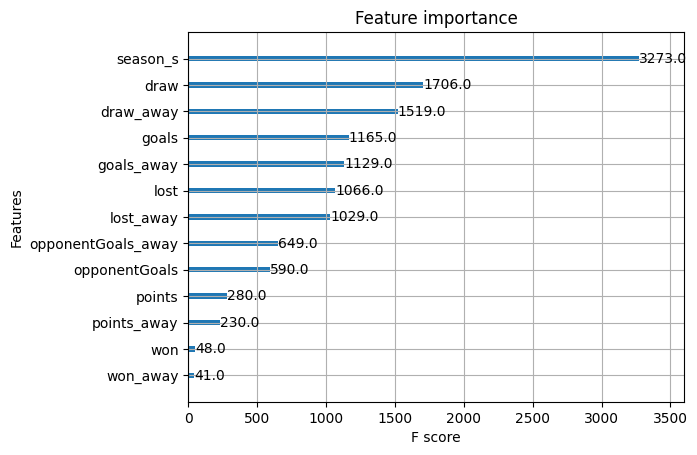

In [13]:
from xgboost import XGBClassifier, plot_importance, XGBRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error

X = df_full.drop(columns=["season", "home_name", "away_name", "winner", "score_1", "score_2", "away_id", "home_id", "diff"])
y = df_full["winner"]
test_len = len(X[X.season_s == 1.0].index // 3)
X_test = X.iloc[-test_len:]
y_test = y.iloc[-test_len:]
X_train = X.iloc[:-test_len]
y_train = y.iloc[:-test_len]

print(f"{len(X_train)=} {len(X_test)=}")

sample_weights = X_train["season_s"] * 0.75 + 0.25

winner_predictor = XGBClassifier(max_depth=6)
winner_predictor.fit(X_train, y_train, sample_weight=sample_weights)
predictions_train = winner_predictor.predict(X_train)
acc_train = accuracy_score(y_train, predictions_train)
predictions_test = winner_predictor.predict(X_test)
acc_test = accuracy_score(y_test, predictions_test)
print(f"Train acc {acc_train}")
print(f"Test acc {acc_test}")
plot_importance(winner_predictor)
sample_weights = X["season_s"] * 0.75 + 0.25
winner_predictor.fit(X, y, sample_weight=sample_weights)

len(X_train)=5508 len(X_test)=612
mae_train=np.float64(1.0325160618033125)
mae_test=np.float64(1.2218693087601826)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

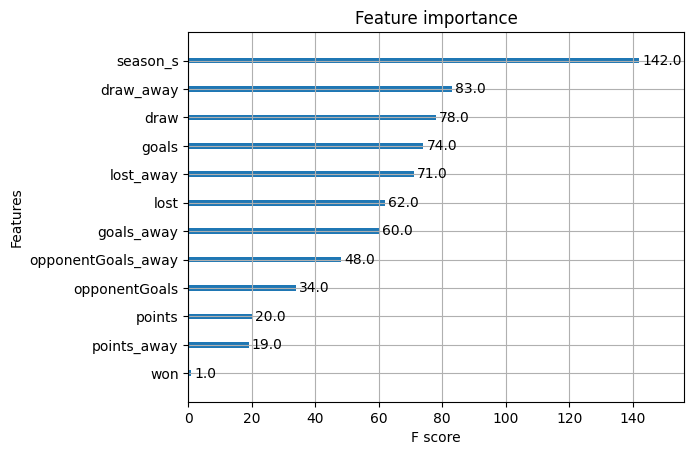

In [14]:
y = df_full["diff"]
test_len = len(X[X.season_s == 1.0].index // 3)
X_test = X.iloc[-test_len:]
y_test = y.iloc[-test_len:]
X_train = X.iloc[:-test_len]
y_train = y.iloc[:-test_len]

print(f"{len(X_train)=} {len(X_test)=}")

sample_weights = X_train["season_s"] * 0.75 + 0.25

diff_regressor = XGBRegressor(min_child_weight=3, max_depth=3)
diff_regressor.fit(X_train, y_train, sample_weight=sample_weights)
predictions_train = diff_regressor.predict(X_train)
mae_train = mean_absolute_error(y_train, predictions_train)
predictions_test = diff_regressor.predict(X_test)
mae_test = mean_absolute_error(y_test, predictions_test)
print(f"{mae_train=}")
print(f"{mae_test=}")
plot_importance(diff_regressor)
sample_weights = X["season_s"] * 0.75 + 0.25
diff_regressor.fit(X, y, sample_weight=sample_weights)

len(X_train)=5508 len(X_test)=612
mae_train=np.float64(0.7871101134503277)
mae_test=np.float64(0.9745683131398621)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

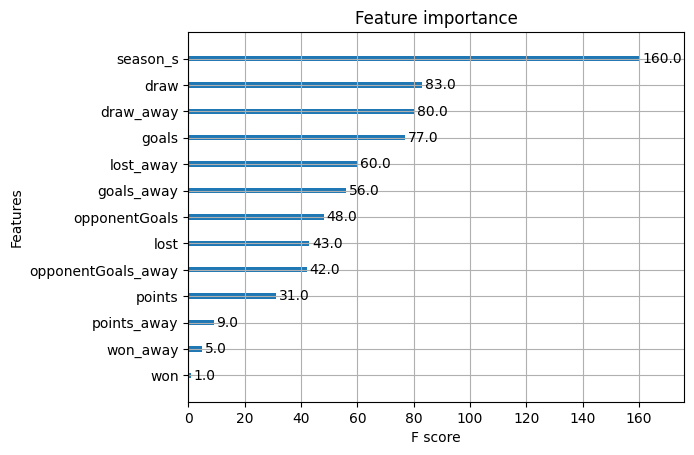

In [15]:
y = df_full["score_1"]
test_len = len(X[X.season_s == 1.0].index // 3)
X_test = X.iloc[-test_len:]
y_test = y.iloc[-test_len:]
X_train = X.iloc[:-test_len]
y_train = y.iloc[:-test_len]

print(f"{len(X_train)=} {len(X_test)=}")

sample_weights = X_train["season_s"] * 0.75 + 0.25

score_1_regressor = XGBRegressor(min_child_weight=3, max_depth=3)
score_1_regressor.fit(X_train, y_train, sample_weight=sample_weights)
predictions_train = score_1_regressor.predict(X_train)
mae_train = mean_absolute_error(y_train, predictions_train)
predictions_test = score_1_regressor.predict(X_test)
mae_test = mean_absolute_error(y_test, predictions_test)
print(f"{mae_train=}")
print(f"{mae_test=}")
plot_importance(score_1_regressor)
sample_weights = X["season_s"] * 0.75 + 0.25
score_1_regressor.fit(X, y, sample_weight=sample_weights)

len(X_train)=5508 len(X_test)=612
mae_train=np.float64(0.7311734247508174)
mae_test=np.float64(0.8899852208994037)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

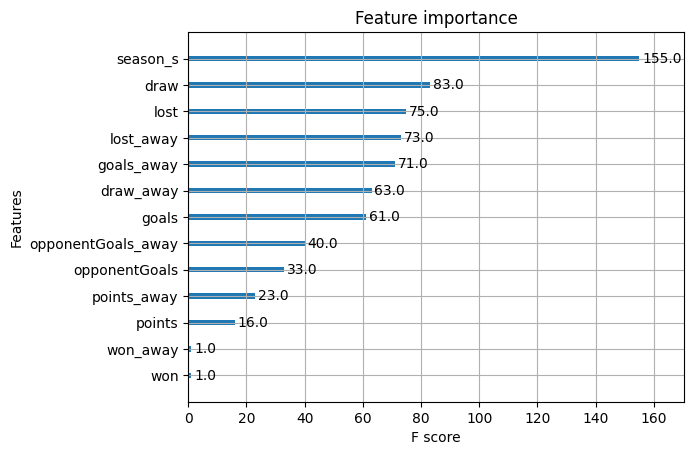

In [16]:
y = df_full["score_2"]
test_len = len(X[X.season_s == 1.0].index // 3)
X_test = X.iloc[-test_len:]
y_test = y.iloc[-test_len:]
X_train = X.iloc[:-test_len]
y_train = y.iloc[:-test_len]

print(f"{len(X_train)=} {len(X_test)=}")

sample_weights = X_train["season_s"] * 0.75 + 0.25

score_2_regressor = XGBRegressor(min_child_weight=3, max_depth=3)
score_2_regressor.fit(X_train, y_train, sample_weight=sample_weights)
predictions_train = score_2_regressor.predict(X_train)
mae_train = mean_absolute_error(y_train, predictions_train)
predictions_test = score_2_regressor.predict(X_test)
mae_test = mean_absolute_error(y_test, predictions_test)
print(f"{mae_train=}")
print(f"{mae_test=}")
plot_importance(score_2_regressor)
sample_weights = X["season_s"] * 0.75 + 0.25
score_2_regressor.fit(X, y, sample_weight=sample_weights)

In [17]:
keyword_to_team_id = {}
keyword_to_team_name = {}
for name in df["home_name"].unique():
    tid = df.loc[df["home_name"] == name, "home_id"].values[0]
    parts = name.split(" ")
    parts = [p for p in parts if len(p) >= 4]
    for p in parts:
        if p in keyword_to_team_id:
            print(f"Warning: {p} already in map ({name}, {keyword_to_team_name[p]})")
        else:
            keyword_to_team_id[p] = int(tid)
            keyword_to_team_name[p] = name

del keyword_to_team_id["Borussia"]
del keyword_to_team_id["Eintracht"]
del keyword_to_team_id["München"]
del keyword_to_team_id["Kickers"]

In [18]:
last_season_score = df_teams_all.loc[(df_teams_all.year == "2023") & (df_teams_all.feature == "points"), ["team", "value"]].copy() 
last_season_score["value"] -= last_season_score["value"].min()
last_season_score["value"] /= last_season_score["value"].max()
last_season_score

,team,value
972,6,1.000000
978,16,0.767123
984,40,0.753425
990,1635,0.657534
996,7,0.630137
1002,91,0.410959
1008,175,0.397260
1014,199,0.342466
1020,134,0.342466
1026,112,0.342466


In [39]:

def find_tid(name):
    parts = name.split(" ")
    for p in parts:
        if p in keyword_to_team_id:
            return keyword_to_team_id[p]
    return None



def predict_match_xgb(match):
    home_id = find_tid(match.home_team)
    away_id = find_tid(match.away_team)

    if home_id is None:
        print(f"Warnung: {match.home_team} not assigned to team id")
    if away_id is None:
        print(f"Warnung: {match.away_team} not assigned to team id")

    entry = X.iloc[0].copy()
    entry[:] = 0
    entry["season_s"] = 1.0
    entry_columns = X.columns
    for column in df_teams.columns.values:
        if home_id is not None and home_id in df_teams.index:
            entry[column] = df_teams.loc[df_teams.index == home_id, column].values[0]
        if away_id is not None and away_id in df_teams.index: 
            entry[column+"_away"] = df_teams.loc[df_teams.index == away_id, column].values[0]
    
    last_s_scores = [
        last_season_score.loc[last_season_score.team == home_id, "value"].values[0] if home_id in last_season_score.team.unique() else 0,
        last_season_score.loc[last_season_score.team == away_id, "value"].values[0] if away_id in last_season_score.team.unique() else 0,
    ]
    boni = [last_s_scores[0], np.abs(last_s_scores[0] - last_s_scores[1]), last_s_scores[1]]

    entry = entry[entry_columns]
    winner_prediction = winner_predictor.predict_proba([entry])[0] # [p_home, p_away, p_draw]
    winn_with_bonus = np.array(boni) * 0.5 + winner_prediction
    winner_dist = winn_with_bonus[np.argsort(winn_with_bonus)[2]] - winn_with_bonus[np.argsort(winn_with_bonus)[1]]
    diff_prediction = diff_regressor.predict([entry])[0]
    score_1_prediction = score_1_regressor.predict([entry])[0]
    score_2_prediction = score_2_regressor.predict([entry])[0]
    if winner_dist < 0.7:
        home_tip = round(score_1_prediction)
        away_tip = round(score_2_prediction)
    elif np.argmax(winn_with_bonus) == 0:
        home_tip = np.ceil(score_1_prediction).astype(int)
        diff_prediction = np.max((1, diff_prediction))
        away_tip = np.floor(score_1_prediction - diff_prediction).astype(int)
    elif np.argmax(winn_with_bonus) == 2:
        away_tip = np.ceil(score_2_prediction).astype(int)
        diff_prediction = np.max((1, diff_prediction))
        home_tip = np.floor(score_2_prediction - diff_prediction).astype(int)
    else:
        away_tip = round(np.mean([score_1_prediction, score_2_prediction]))
        home_tip = round(np.mean([score_1_prediction, score_2_prediction]))

    home_tip, away_tip = max(0, home_tip), max(0, away_tip)
    return MatchTip(match.match_day, match.match_id, match.home_team, match.away_team, home_tip, away_tip)

community_predictions = {}
for community in communities:
    all_predictions = []
    for match_day in range(1, 35):
        matches = get_matches(browser, community, match_day)
        predictions = [predict_match_xgb(m) for m in matches]
        all_predictions += predictions
        make_tipps(browser, community, predictions)
    community_predictions[community] = all_predictions

def compute_table(predictions: list[MatchTip]):
    team_id_to_points = {}
    for p in predictions:
        if p.home_team not in team_id_to_points:
            team_id_to_points[p.home_team] = 0
        if p.away_team not in team_id_to_points:
            team_id_to_points[p.away_team] = 0
        if p.home_tip > p.away_tip:
            team_id_to_points[p.home_team] += 3
        elif p.home_tip < p.away_tip:
            team_id_to_points[p.away_team] += 3
        elif p.home_tip == p.away_tip:
            team_id_to_points[p.home_team] += 1
            team_id_to_points[p.away_team] += 1
    rows = zip(team_id_to_points.keys(), team_id_to_points.values())
    return pd.DataFrame(rows, columns=["team", "points"]).sort_values("points", ascending=False)

compute_table(community_predictions["bundesligavorgetippt"])

Placing bets for matchday 1
1:3   Bor. Mönchengladbach : Bayer 04 Leverkusen
1:1   1899 Hoffenheim : Holstein Kiel
3:0   RB Leipzig : VfL Bochum
1:1   FC Augsburg : Werder Bremen
0:2   SC Freiburg : VfB Stuttgart
1:1   FSV Mainz 05 : 1. FC Union Berlin
3:1   Borussia Dortmund : Eintracht Frankfurt
1:3   VfL Wolfsburg : FC Bayern München
1:1   FC St. Pauli : 1. FC Heidenheim 1846
Placing bets for matchday 2
2:1   1. FC Union Berlin : FC St. Pauli
3:1   VfB Stuttgart : FSV Mainz 05
0:2   Holstein Kiel : VfL Wolfsburg
2:2   VfL Bochum : Bor. Mönchengladbach
3:1   Eintracht Frankfurt : 1899 Hoffenheim
1:2   Werder Bremen : Borussia Dortmund
2:0   Bayer 04 Leverkusen : RB Leipzig
2:4   1. FC Heidenheim 1846 : FC Augsburg
3:0   FC Bayern München : SC Freiburg
Placing bets for matchday 3
3:1   Borussia Dortmund : 1. FC Heidenheim 1846
3:0   RB Leipzig : 1. FC Union Berlin
2:1   Bor. Mönchengladbach : VfB Stuttgart
2:1   SC Freiburg : VfL Bochum
1:3   1899 Hoffenheim : Bayer 04 Leverkusen
2:2 

,team,points
1,Bayer 04 Leverkusen,91
15,FC Bayern München,86
12,Borussia Dortmund,81
4,RB Leipzig,80
9,VfB Stuttgart,67
13,Eintracht Frankfurt,51
0,Bor. Mönchengladbach,47
8,SC Freiburg,43
2,1899 Hoffenheim,42
14,VfL Wolfsburg,35
